# Анализ статистик гессианов

Этот ноутбук анализирует сохраненные гессианы из экспериментов exp15:
- Начальные гессианы (до обучения)
- Гессианы после обучения

## Анализируемые статистики:
1. **Сингулярные числа** - их среднее и дисперсия
2. **Коммутатор матриц** среднего гессиана и среднего квадрата гессиана
3. **Флуктуации собственных значений** гессиана

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from scipy.linalg import svd, eigvals
import pandas as pd
from pathlib import Path
import random



plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Пути к данным
DATA_DIR = Path("../../data/checkpoints/exp15")
INITIAL_HESSIANS_PATH = DATA_DIR / "initial_hessians.pkl"
TRAINED_HESSIANS_PATH = DATA_DIR / "trained_hessians.pkl"

## 1. Загрузка данных

In [2]:
# Загрузка гессианов
with open(INITIAL_HESSIANS_PATH, 'rb') as f:
    initial_hessians = pickle.load(f)

with open(TRAINED_HESSIANS_PATH, 'rb') as f:
    trained_hessians = pickle.load(f)

print("Загружены гессианы:")
print(f"Начальные: {list(initial_hessians.keys())} batch sizes")
print(f"После обучения: {list(trained_hessians.keys())} batch sizes")

# Проверим размеры
for batch_size in initial_hessians.keys():
    n_initial = len(initial_hessians[batch_size])
    n_trained = len(trained_hessians[batch_size])
    shape = initial_hessians[batch_size][0].shape if n_initial > 0 else "N/A"
    print(f"Batch {batch_size}: {n_initial} начальных, {n_trained} обученных, размер: {shape}")

Загружены гессианы:
Начальные: [2, 4, 8, 16, 32, 64] batch sizes
После обучения: [2, 4, 8, 16, 32, 64] batch sizes
Batch 2: 1000 начальных, 1000 обученных, размер: (386, 386)
Batch 4: 1000 начальных, 1000 обученных, размер: (386, 386)
Batch 8: 1000 начальных, 1000 обученных, размер: (386, 386)
Batch 16: 1000 начальных, 1000 обученных, размер: (386, 386)
Batch 32: 1000 начальных, 1000 обученных, размер: (386, 386)
Batch 64: 1000 начальных, 1000 обученных, размер: (386, 386)


## Визуализация пары гессианов

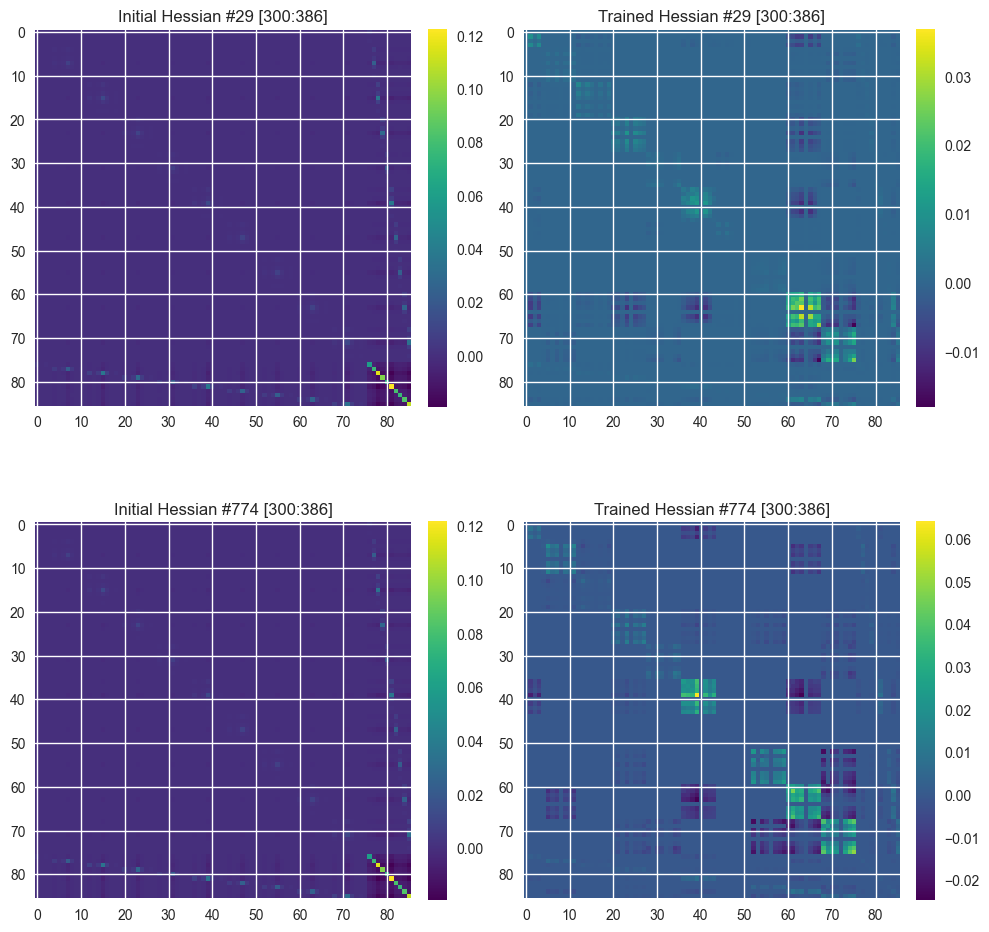

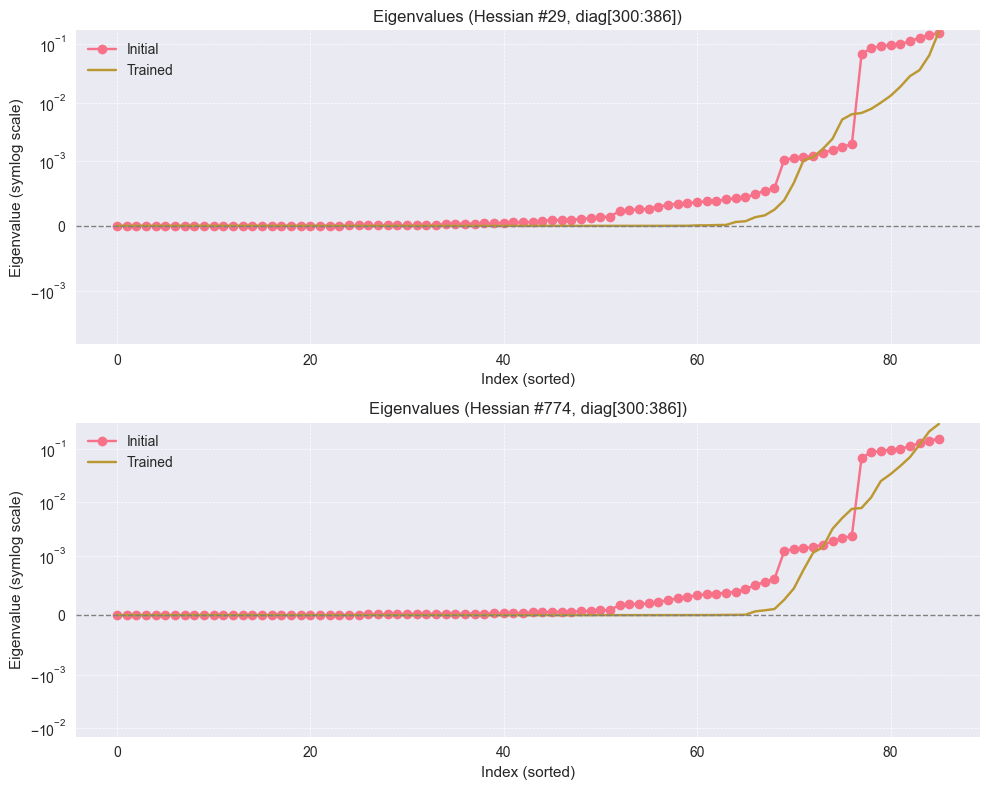

In [3]:
import random
import matplotlib.pyplot as plt
import numpy as np

# Параметры
batch_size = 32
num_to_plot = 2
start_idx = 300
size = 86

# Проверка границ
hessian_dim = initial_hessians[batch_size][0].shape[0]
if start_idx + size > hessian_dim:
    raise ValueError(f"start_idx + size = {start_idx + size} выходит за пределы матрицы {hessian_dim}×{hessian_dim}")

# Выбор случайных индексов
max_index = min(len(initial_hessians[batch_size]), len(trained_hessians[batch_size]))
selected_indices = random.sample(range(max_index), k=num_to_plot)

# === Визуализация гессианов ===
fig, axes = plt.subplots(num_to_plot, 2, figsize=(10, 5 * num_to_plot))

for i, idx in enumerate(selected_indices):
    init_hess = initial_hessians[batch_size][idx]
    trained_hess = trained_hessians[batch_size][idx]

    init_crop = init_hess[start_idx:start_idx+size, start_idx:start_idx+size]
    trained_crop = trained_hess[start_idx:start_idx+size, start_idx:start_idx+size]

    ax1 = axes[i, 0] if num_to_plot > 1 else axes[0]
    ax2 = axes[i, 1] if num_to_plot > 1 else axes[1]

    im1 = ax1.imshow(init_crop, cmap='viridis')
    ax1.set_title(f"Initial Hessian #{idx} [{start_idx}:{start_idx+size}]")
    fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)

    im2 = ax2.imshow(trained_crop, cmap='viridis')
    ax2.set_title(f"Trained Hessian #{idx} [{start_idx}:{start_idx+size}]")
    fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

# === Визуализация собственных значений ===
fig, axes = plt.subplots(num_to_plot, 1, figsize=(10, 4 * num_to_plot))

for i, idx in enumerate(selected_indices):
    init_hess = initial_hessians[batch_size][idx][start_idx:start_idx+size, start_idx:start_idx+size]
    trained_hess = trained_hessians[batch_size][idx][start_idx:start_idx+size, start_idx:start_idx+size]

    eig_init = np.linalg.eigvalsh(init_hess)   # для симметричных матриц
    eig_trained = np.linalg.eigvalsh(trained_hess)

    ax = axes[i] if num_to_plot > 1 else axes
    ax.plot(np.sort(eig_init), label='Initial', marker='o')
    ax.plot(np.sort(eig_trained), label='Trained', marker='x')
    ax.axhline(0, color='gray', linestyle='--', linewidth=1)

    ax.set_yscale('symlog', linthresh=1e-3)  # симметричный логарифм с линейной зоной вокруг 0
    ax.set_title(f"Eigenvalues (Hessian #{idx}, diag[{start_idx}:{start_idx+size}])")
    ax.set_xlabel("Index (sorted)")
    ax.set_ylabel("Eigenvalue (symlog scale)")
    ax.legend()
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()


## 2. Анализ сингулярных чисел

In [4]:
# %% [markdown]
# ## 2. Функции для статистики

# %%
def get_singular_stats(hessians):
    """Вычисляет среднее и дисперсию сингулярных чисел"""
    stats = []
    for h in hessians:
        s = svd(h, compute_uv=False)
        stats.append({
            'mean': np.mean(s),
            'std': np.std(s),
            'max': np.max(s),
            'min': np.min(s),
        })
    return pd.DataFrame(stats)

def commutator(A, B):
    """[A, B] = AB - BA"""
    return A @ B - B @ A

def frobenius_norm_squared(M):
    return np.sum(M ** 2)

def get_commutator_stats(hessians):
    """Считает норму коммутатора между средним гессианом и средним квадратом"""
    hs = np.stack(hessians)
    H = np.mean(hs, axis=0)
    H2 = np.mean(hs @ hs, axis=0)
    comm = commutator(H, H2)
    return frobenius_norm_squared(comm)

def eigenvalue_fluctuations(hessians):
    """Вычисляет флуктуации спектра"""
    results = []
    for h in hessians:
        eigs = eigvals(h)
        eigs = np.real(eigs)  # убрать мнимые части (на всякий)
        results.append({
            'mean': np.mean(eigs),
            'std': np.std(eigs),
            'min': np.min(eigs),
            'max': np.max(eigs),
            'num_negative': np.sum(eigs < 0),
            'total': len(eigs),
        })
    return pd.DataFrame(results)

# %% [markdown]
# ## 3. Подсчёт статистик по всем batch_size

# %%
batch_stats = []

for batch_size in sorted(initial_hessians.keys()):
    init_hess = initial_hessians[batch_size]
    train_hess = trained_hessians[batch_size]

    # Сингулярные числа
    init_svd = get_singular_stats(init_hess)
    train_svd = get_singular_stats(train_hess)

    # Коммутаторы
    init_comm_norm = get_commutator_stats(init_hess)
    train_comm_norm = get_commutator_stats(train_hess)

    # Спектры
    init_eig = eigenvalue_fluctuations(init_hess)
    train_eig = eigenvalue_fluctuations(train_hess)

    batch_stats.append({
        'batch_size': batch_size,
        'init_svd_mean': init_svd['mean'].mean(),
        'init_svd_std': init_svd['std'].mean(),
        'train_svd_mean': train_svd['mean'].mean(),
        'train_svd_std': train_svd['std'].mean(),
        'init_comm_norm': init_comm_norm,
        'train_comm_norm': train_comm_norm,
        'init_eig_std': init_eig['std'].mean(),
        'train_eig_std': train_eig['std'].mean(),
        'init_neg_frac': init_eig['num_negative'].sum() / init_eig['total'].sum(),
        'train_neg_frac': train_eig['num_negative'].sum() / train_eig['total'].sum(),
    })

summary_df = pd.DataFrame(batch_stats)

# %%
summary_df.set_index('batch_size')


,init_svd_mean,init_svd_std,train_svd_mean,train_svd_std,init_comm_norm,train_comm_norm,init_eig_std,train_eig_std,init_neg_frac,train_neg_frac
batch_size,,,,,,,,,,
2,0.029165,0.154167,0.007561,0.125518,0.173399,1.008659,0.156893,0.125401,0.160938,0.269746
4,0.026241,0.111176,0.007454,0.111767,0.042745,0.179133,0.114213,0.111775,0.190155,0.308119
8,0.023043,0.081701,0.007439,0.096872,0.010323,0.049212,0.084849,0.096879,0.224407,0.333733
16,0.020120,0.062649,0.007421,0.080932,0.002580,0.011748,0.065729,0.080939,0.255337,0.351223
32,0.017475,0.050362,0.007390,0.068335,0.000602,0.003007,0.053203,0.068340,0.241718,0.350904
64,0.015592,0.043004,0.007379,0.059554,0.000121,0.000546,0.045613,0.059558,0.228461,0.320552


## 4. Графики

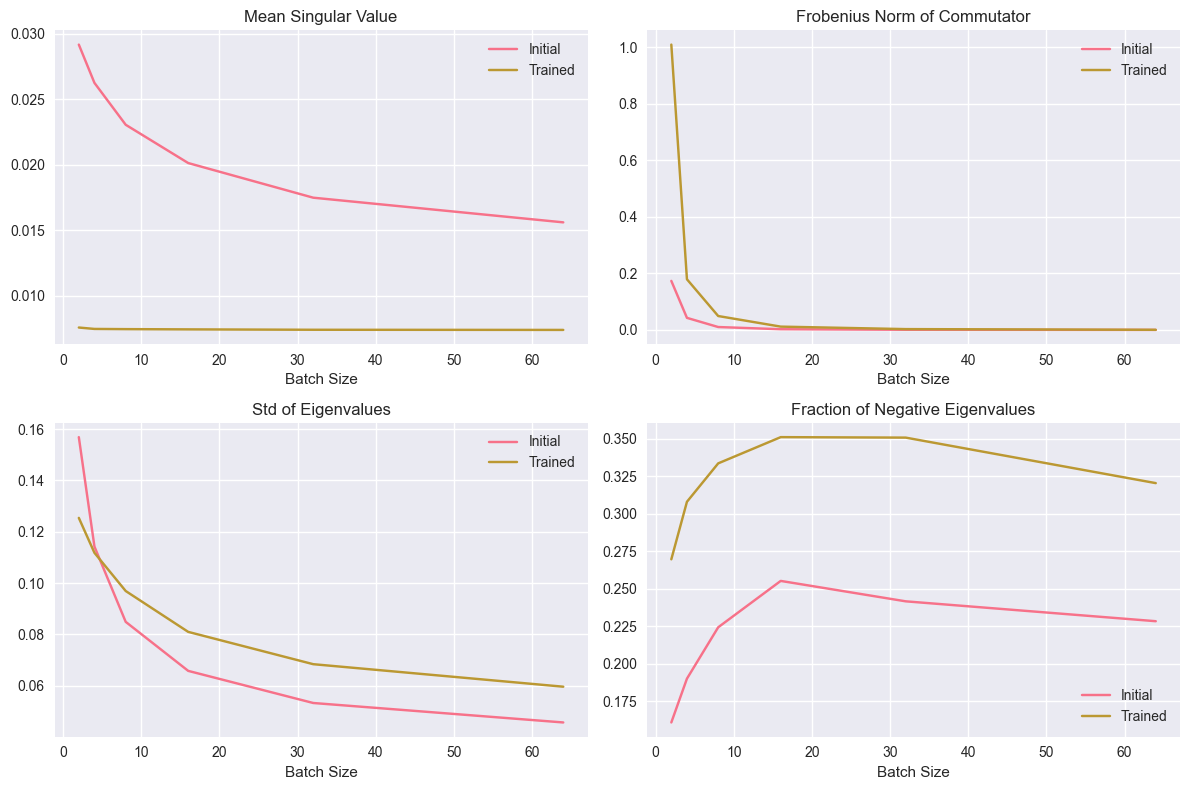

In [5]:

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes[0, 0].plot(summary_df['batch_size'], summary_df['init_svd_mean'], label='Initial')
axes[0, 0].plot(summary_df['batch_size'], summary_df['train_svd_mean'], label='Trained')
axes[0, 0].set_title('Mean Singular Value')
axes[0, 0].set_xlabel('Batch Size')
axes[0, 0].legend()

axes[0, 1].plot(summary_df['batch_size'], summary_df['init_comm_norm'], label='Initial')
axes[0, 1].plot(summary_df['batch_size'], summary_df['train_comm_norm'], label='Trained')
axes[0, 1].set_title('Frobenius Norm of Commutator')
axes[0, 1].set_xlabel('Batch Size')
axes[0, 1].legend()

axes[1, 0].plot(summary_df['batch_size'], summary_df['init_eig_std'], label='Initial')
axes[1, 0].plot(summary_df['batch_size'], summary_df['train_eig_std'], label='Trained')
axes[1, 0].set_title('Std of Eigenvalues')
axes[1, 0].set_xlabel('Batch Size')
axes[1, 0].legend()

axes[1, 1].plot(summary_df['batch_size'], summary_df['init_neg_frac'], label='Initial')
axes[1, 1].plot(summary_df['batch_size'], summary_df['train_neg_frac'], label='Trained')
axes[1, 1].set_title('Fraction of Negative Eigenvalues')
axes[1, 1].set_xlabel('Batch Size')
axes[1, 1].legend()

plt.tight_layout()
plt.show()


## 5. Подробные графики: сингулярные и собственные значения


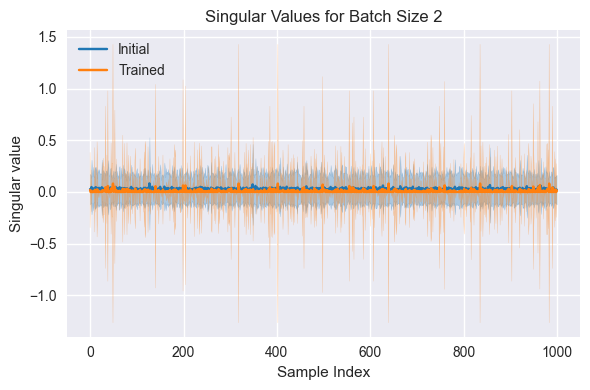

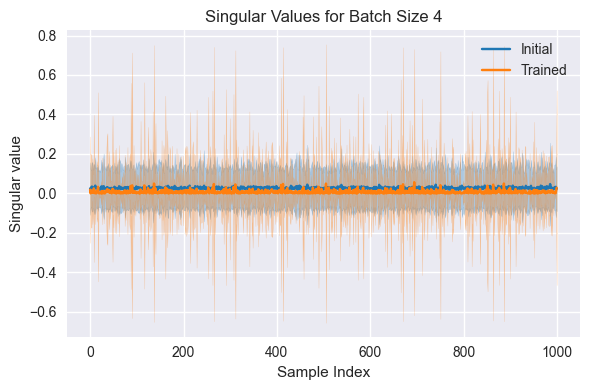

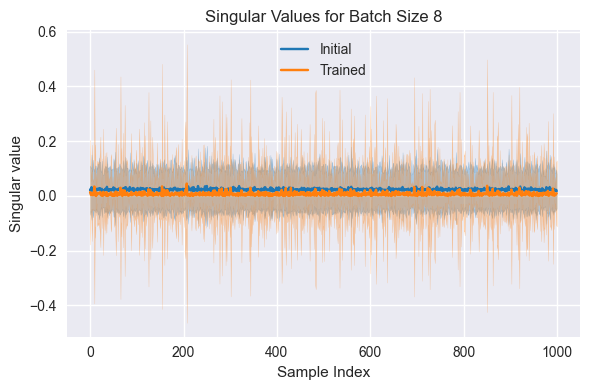

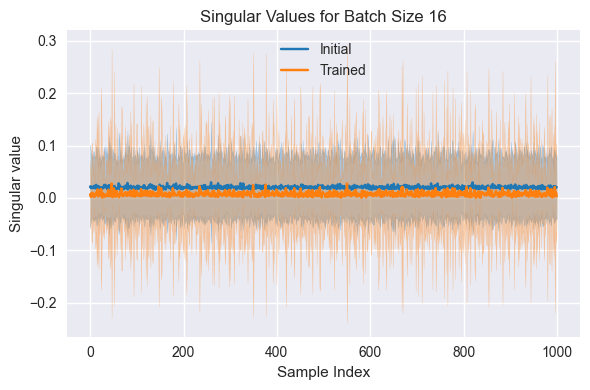

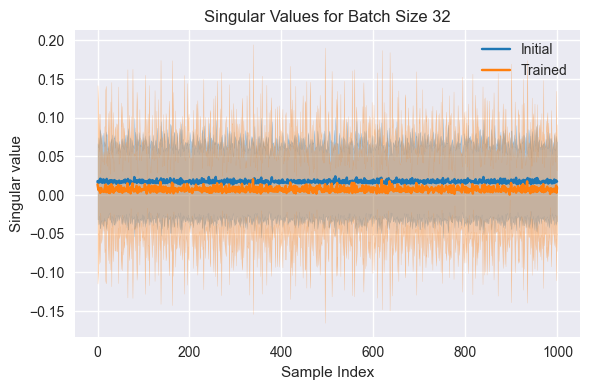

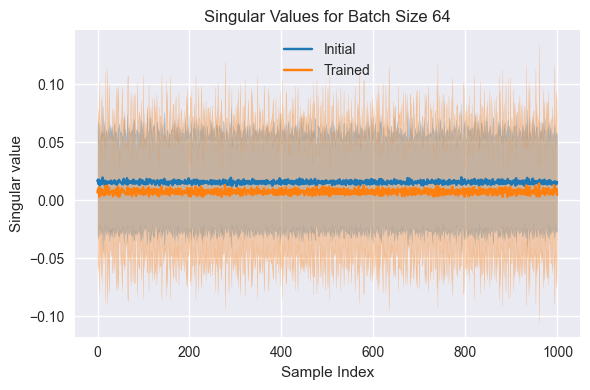

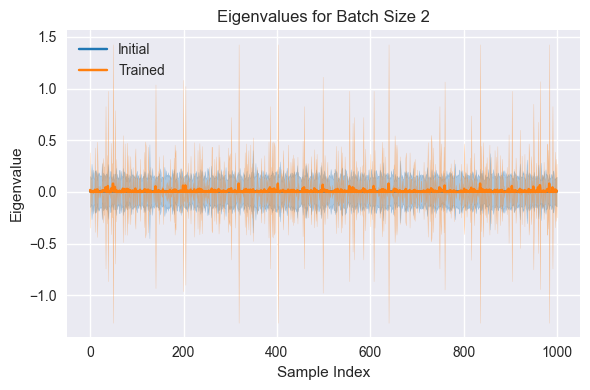

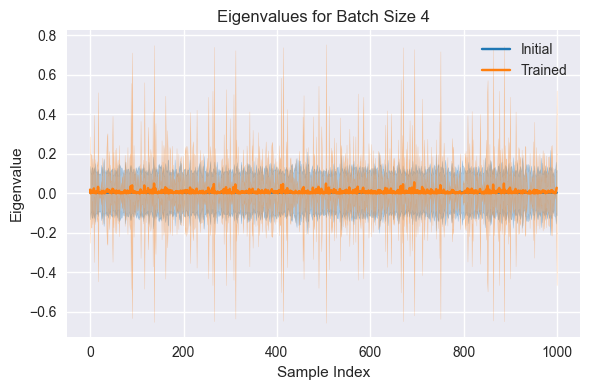

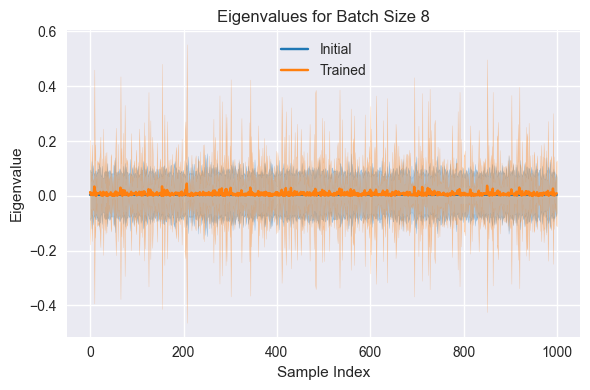

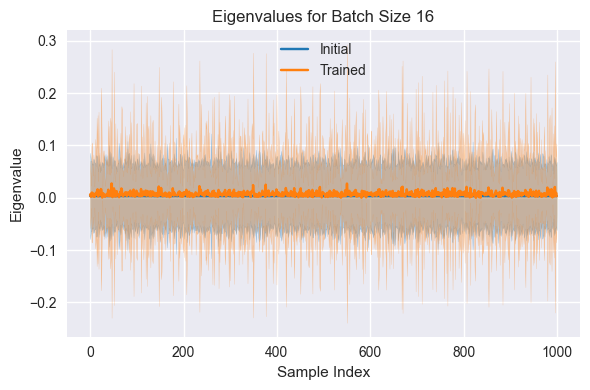

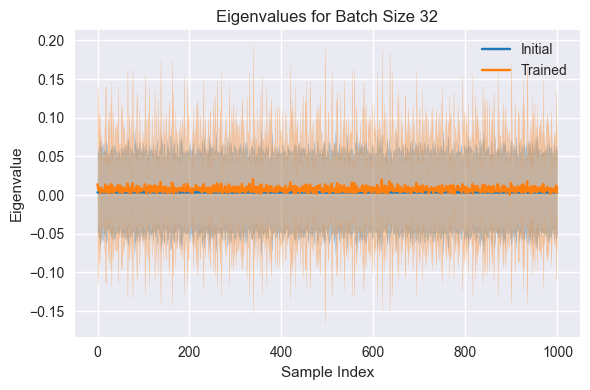

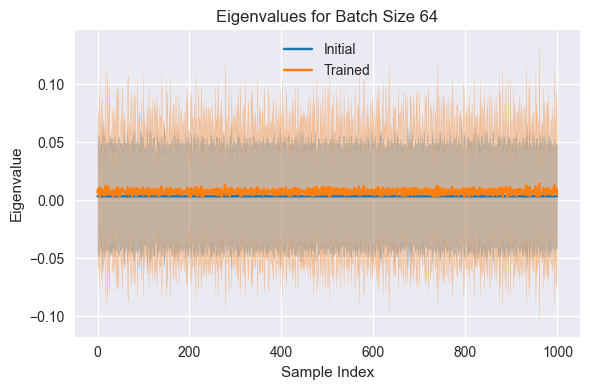

In [6]:

def plot_mean_std(values_df, title, ylabel, key_mean, key_std, labels=('Initial', 'Trained')):
    fig, ax = plt.subplots(figsize=(6, 4))
    x = np.arange(len(values_df))

    # Plot with fill-between for std
    for label, color, prefix in zip(labels, ['tab:blue', 'tab:orange'], ['init_', 'train_']):
        mean = values_df[f'{prefix}{key_mean}']
        std = values_df[f'{prefix}{key_std}']
        ax.plot(x, mean, label=label, color=color)
        ax.fill_between(x, mean - std, mean + std, color=color, alpha=0.3)

    ax.set_title(title)
    ax.set_xlabel('Sample Index')
    ax.set_ylabel(ylabel)
    ax.legend()
    return fig, ax

# %% [markdown]
# ### 5.1 По каждому batch_size — сингулярные значения

# %%
for batch_size in sorted(initial_hessians.keys()):
    init_svd_df = get_singular_stats(initial_hessians[batch_size])
    train_svd_df = get_singular_stats(trained_hessians[batch_size])

    svd_df = pd.DataFrame({
        'init_mean': init_svd_df['mean'],
        'init_std': init_svd_df['std'],
        'train_mean': train_svd_df['mean'],
        'train_std': train_svd_df['std'],
    })

    fig, ax = plot_mean_std(
        svd_df,
        title=f"Singular Values for Batch Size {batch_size}",
        ylabel="Singular value",
        key_mean="mean",
        key_std="std"
    )
    plt.tight_layout()
    plt.show()

# %% [markdown]
# ### 5.2 По каждому batch_size — собственные значения

# %%
for batch_size in sorted(initial_hessians.keys()):
    init_eig_df = eigenvalue_fluctuations(initial_hessians[batch_size])
    train_eig_df = eigenvalue_fluctuations(trained_hessians[batch_size])

    eig_df = pd.DataFrame({
        'init_mean': init_eig_df['mean'],
        'init_std': init_eig_df['std'],
        'train_mean': train_eig_df['mean'],
        'train_std': train_eig_df['std'],
    })

    fig, ax = plot_mean_std(
        eig_df,
        title=f"Eigenvalues for Batch Size {batch_size}",
        ylabel="Eigenvalue",
        key_mean="mean",
        key_std="std"
    )
    plt.tight_layout()
    plt.show()


## 3. Коммутатор матриц среднего гессиана и среднего квадрата гессиана

Коммутатор $[A, B] = AB - BA$ показывает, могут ли две матрицы быть одновременно диагонализованы. Если коммутатор равен нулю, значит $A$ и $B$ коммутируют и могут быть диагонализованы одной и той же матрицей. Это важно, так как совпадение собственных направлений у $\mathbb{E}[H]$ и $\mathbb{E}[H^2]$ может говорить об устойчивости направления кривизны и градиента.

Здесь мы считаем норму Фробениуса $\|[H, H^2]\|_F^2$ для разных batch size.


## Коммутатор между средним гессианом и средним квадратом


In [20]:
commutator_norms = []

for batch_size in sorted(initial_hessians.keys()):
    init_Hs = np.stack(initial_hessians[batch_size])
    train_Hs = np.stack(trained_hessians[batch_size])

    H_init = np.mean(init_Hs, axis=0)
    H2_init = np.mean(np.matmul(init_Hs, init_Hs), axis=0)
    comm_init = H_init @ H2_init - H2_init @ H_init
    rel_norm_init = np.linalg.norm(comm_init, ord='fro') / (
        np.linalg.norm(H_init, ord='fro') * np.linalg.norm(H2_init, ord='fro')
    )

    H_train = np.mean(train_Hs, axis=0)
    H2_train = np.mean(np.matmul(train_Hs, train_Hs), axis=0)
    comm_train = H_train @ H2_train - H2_train @ H_train
    rel_norm_train = np.linalg.norm(comm_train, ord='fro') / (
        np.linalg.norm(H_train, ord='fro') * np.linalg.norm(H2_train, ord='fro')
    )

    commutator_norms.append({
        'batch_size': batch_size,
        'comm_init': rel_norm_init,
        'comm_trained': rel_norm_train
    })

comm_df = pd.DataFrame(commutator_norms)


### Визуализация нормы коммутатора

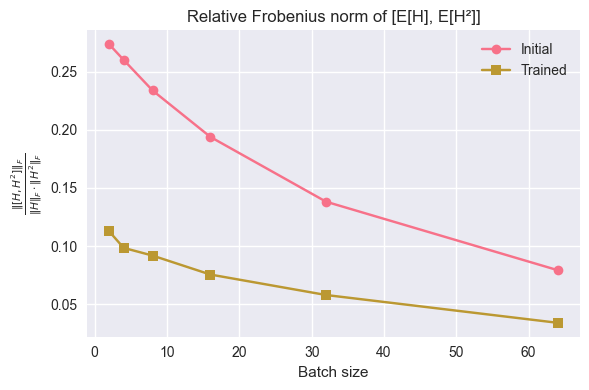

In [21]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(comm_df['batch_size'], comm_df['comm_init'], label='Initial', marker='o')
ax.plot(comm_df['batch_size'], comm_df['comm_trained'], label='Trained', marker='s')

ax.set_title('Relative Frobenius norm of [E[H], E[H²]]')
ax.set_xlabel('Batch size')
ax.set_ylabel(r'$\frac{\|[H, H^2]\|_F}{\|H\|_F \cdot \|H^2\|_F}$')
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()


## 4. Анализ флуктуаций собственных значений

Собственные значения гессиана характеризуют локальную кривизну функции потерь. Их флуктуации и наличие отрицательных значений могут указывать на наличие седловых точек и нестабильность оптимизации.

Мы изучим:
- Среднее и стандартное отклонение собственных значений
- Долю отрицательных собственных значений
- Распределение спектра для разных batch size до и после обучения


### Сбор статистик по собственным значениям

In [9]:

# %%
eig_stats = []

for batch_size in sorted(initial_hessians.keys()):
    init_eig = eigenvalue_fluctuations(initial_hessians[batch_size])
    train_eig = eigenvalue_fluctuations(trained_hessians[batch_size])

    eig_stats.append({
        'batch_size': batch_size,
        'init_mean': init_eig['mean'].mean(),
        'train_mean': train_eig['mean'].mean(),
        'init_std': init_eig['std'].mean(),
        'train_std': train_eig['std'].mean(),
        'init_neg_frac': init_eig['num_negative'].sum() / init_eig['total'].sum(),
        'train_neg_frac': train_eig['num_negative'].sum() / train_eig['total'].sum(),
    })

eig_df = pd.DataFrame(eig_stats)


### Графики статистик собственных значений

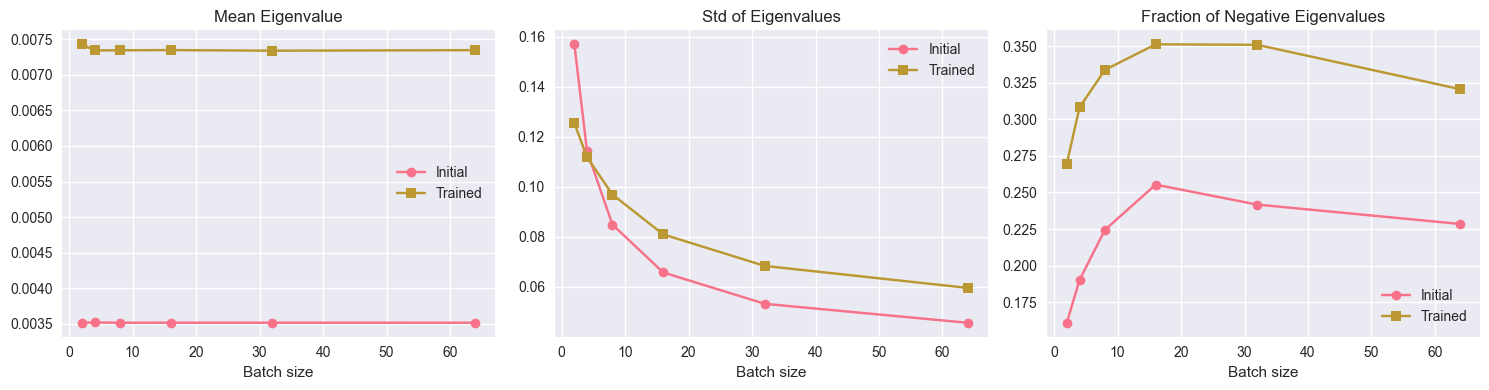

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(eig_df['batch_size'], eig_df['init_mean'], label='Initial', marker='o')
axes[0].plot(eig_df['batch_size'], eig_df['train_mean'], label='Trained', marker='s')
axes[0].set_title('Mean Eigenvalue')
axes[0].set_xlabel('Batch size')
axes[0].grid(True)

axes[1].plot(eig_df['batch_size'], eig_df['init_std'], label='Initial', marker='o')
axes[1].plot(eig_df['batch_size'], eig_df['train_std'], label='Trained', marker='s')
axes[1].set_title('Std of Eigenvalues')
axes[1].set_xlabel('Batch size')
axes[1].grid(True)

axes[2].plot(eig_df['batch_size'], eig_df['init_neg_frac'], label='Initial', marker='o')
axes[2].plot(eig_df['batch_size'], eig_df['train_neg_frac'], label='Trained', marker='s')
axes[2].set_title('Fraction of Negative Eigenvalues')
axes[2].set_xlabel('Batch size')
axes[2].grid(True)

for ax in axes:
    ax.legend()

plt.tight_layout()
plt.show()


## Сингулярные значения в лог-масштабе: среднее и std по индексам


In [11]:

def get_svd_arrays(hessian_list):
    """Вычисляет SVD и возвращает массив сингулярных чисел: shape (num_iters, dim)"""
    all_s = []
    for H in hessian_list:
        s = svd(H, compute_uv=False)
        all_s.append(s)
    return np.stack(all_s)  # shape: (num_iters, num_params)



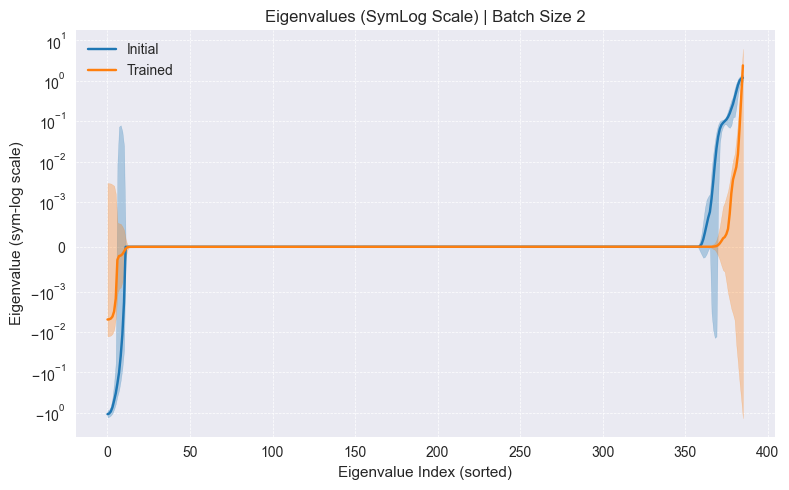

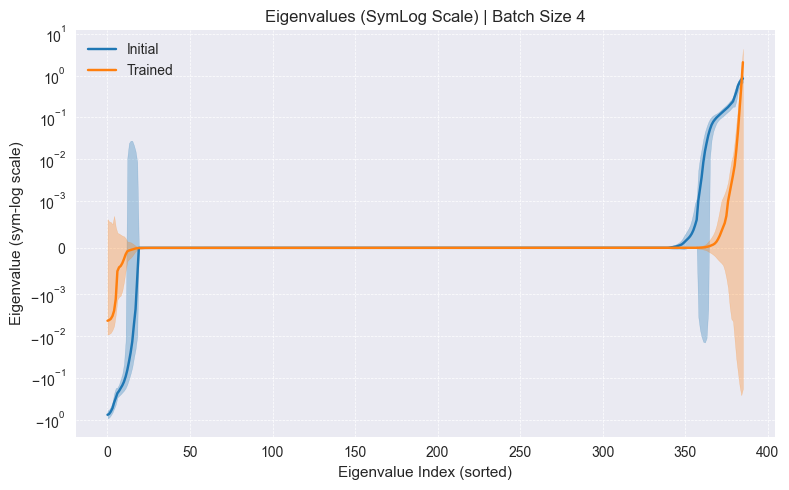

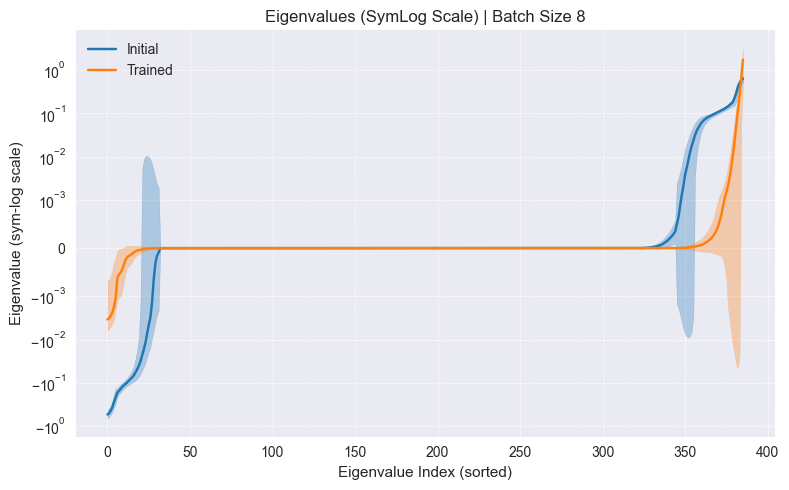

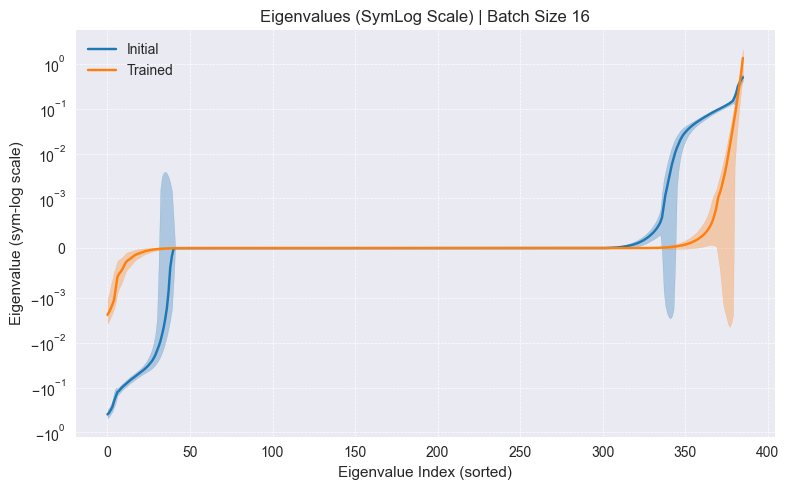

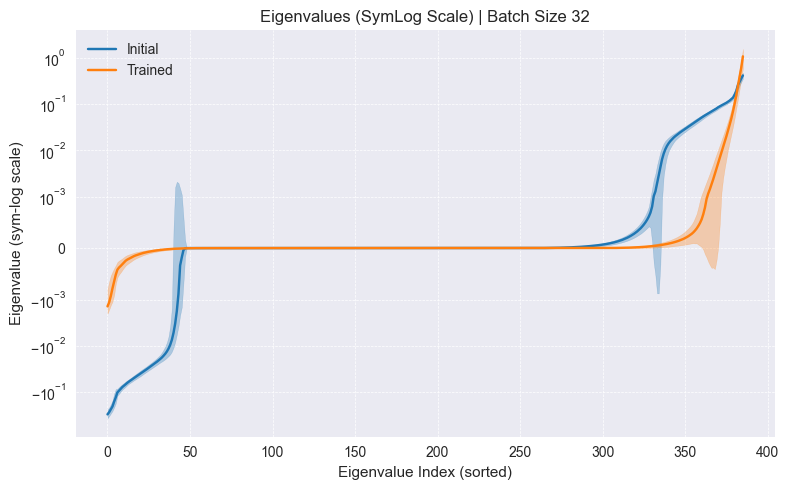

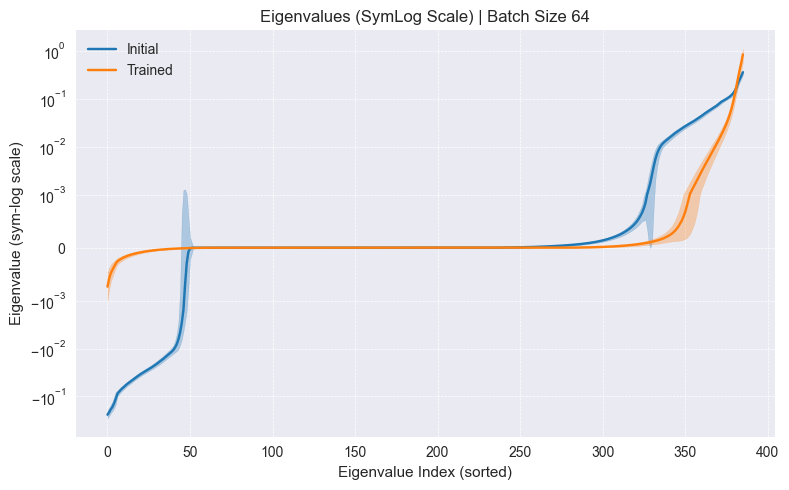

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def get_eig_arrays(hessians):
    """Возвращает массив отсортированных собственных значений для каждой матрицы"""
    eigs_list = []
    for h in hessians:
        eigs = np.linalg.eigvalsh(h)  # для симметричных матриц
        eigs_sorted = np.sort(eigs)
        eigs_list.append(eigs_sorted)
    return np.array(eigs_list)

for batch_size in sorted(initial_hessians.keys()):
    init_eigs = get_eig_arrays(initial_hessians[batch_size])
    train_eigs = get_eig_arrays(trained_hessians[batch_size])

    mean_init = np.mean(init_eigs, axis=0)
    std_init = np.std(init_eigs, axis=0)

    mean_train = np.mean(train_eigs, axis=0)
    std_train = np.std(train_eigs, axis=0)

    x = np.arange(len(mean_init))  # индексы собственных значений

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(x, mean_init, label="Initial", color="tab:blue")
    ax.fill_between(x, mean_init - std_init, mean_init + std_init, alpha=0.3, color="tab:blue")

    ax.plot(x, mean_train, label="Trained", color="tab:orange")
    ax.fill_between(x, mean_train - std_train, mean_train + std_train, alpha=0.3, color="tab:orange")

    ax.set_yscale('symlog', linthresh=1e-3)  # симметричный лог, линейная зона около 0
    ax.set_title(f"Eigenvalues (SymLog Scale) | Batch Size {batch_size}")
    ax.set_xlabel("Eigenvalue Index (sorted)")
    ax.set_ylabel("Eigenvalue (sym-log scale)")
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.legend()
    plt.tight_layout()
    plt.show()


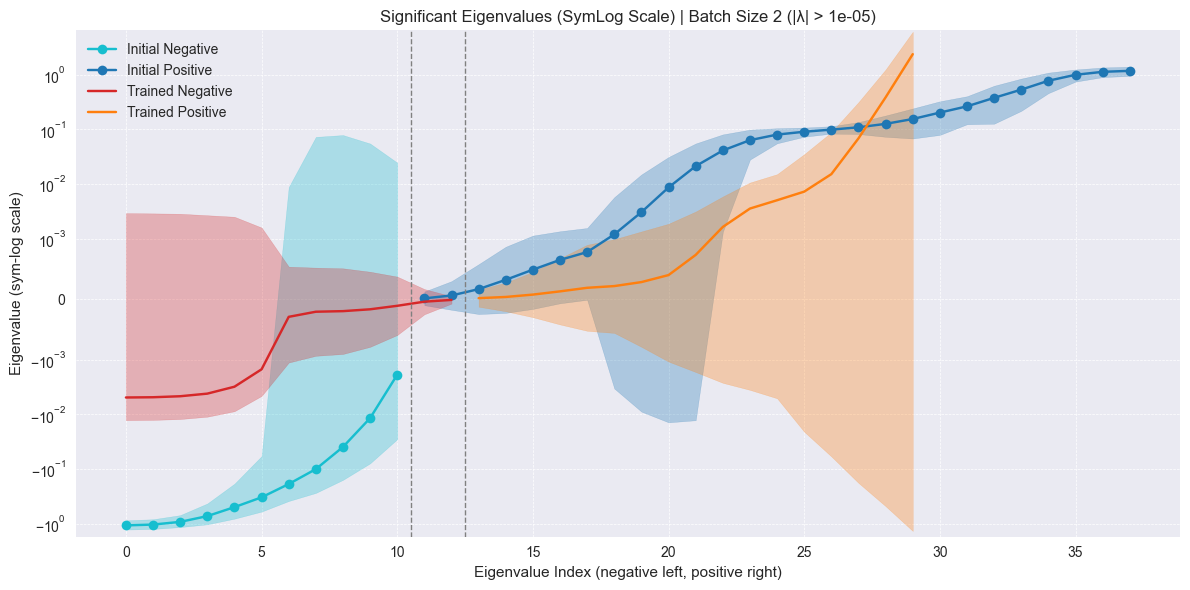

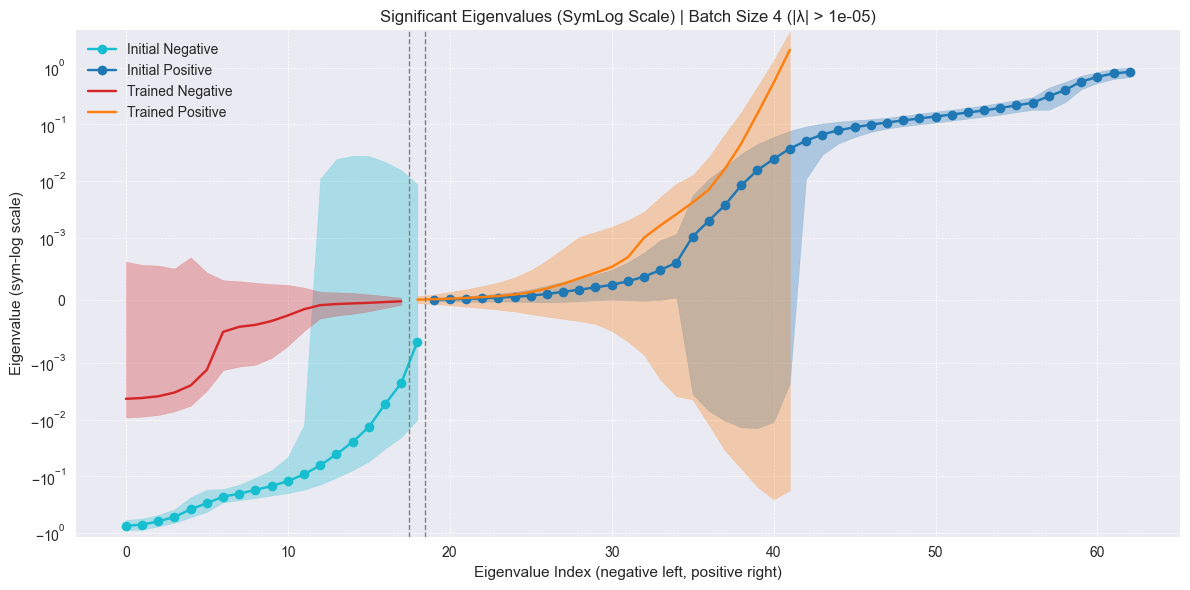

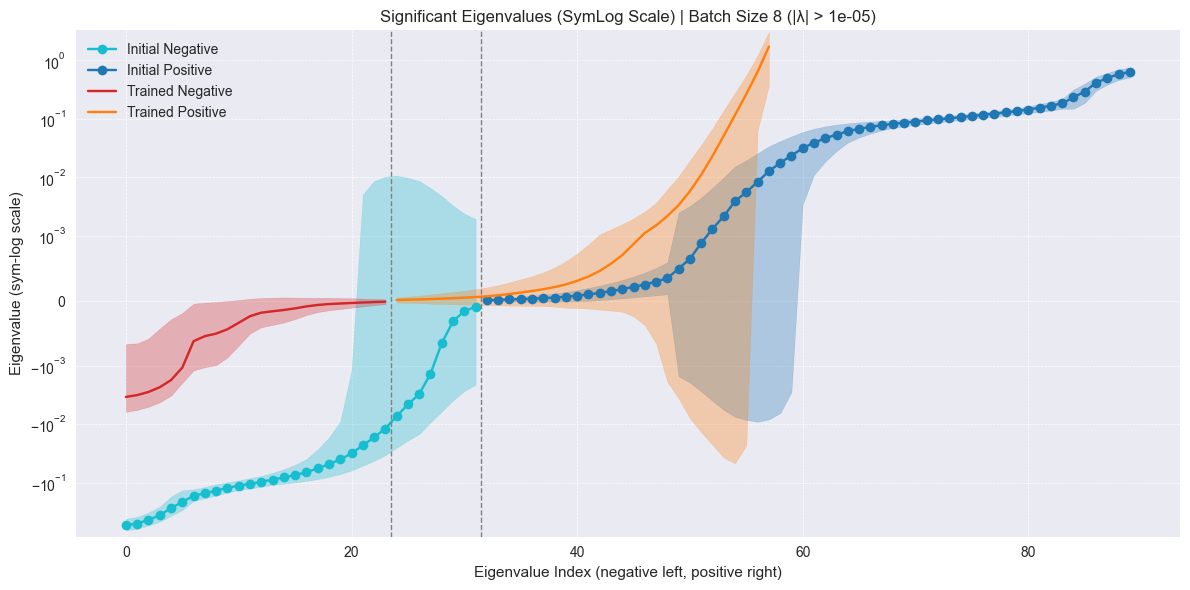

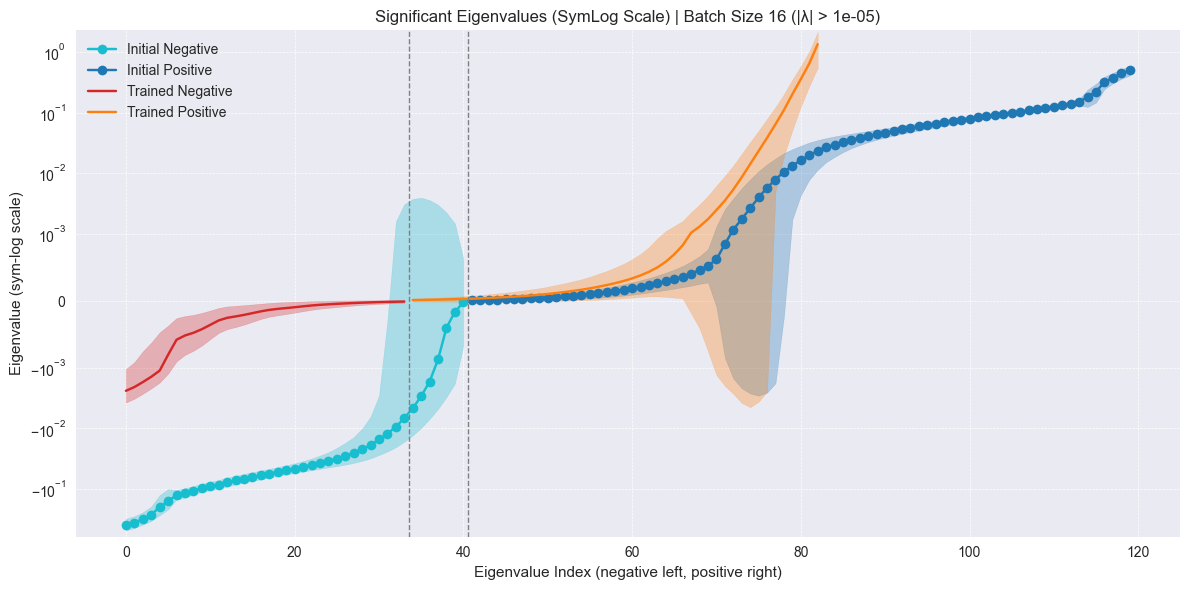

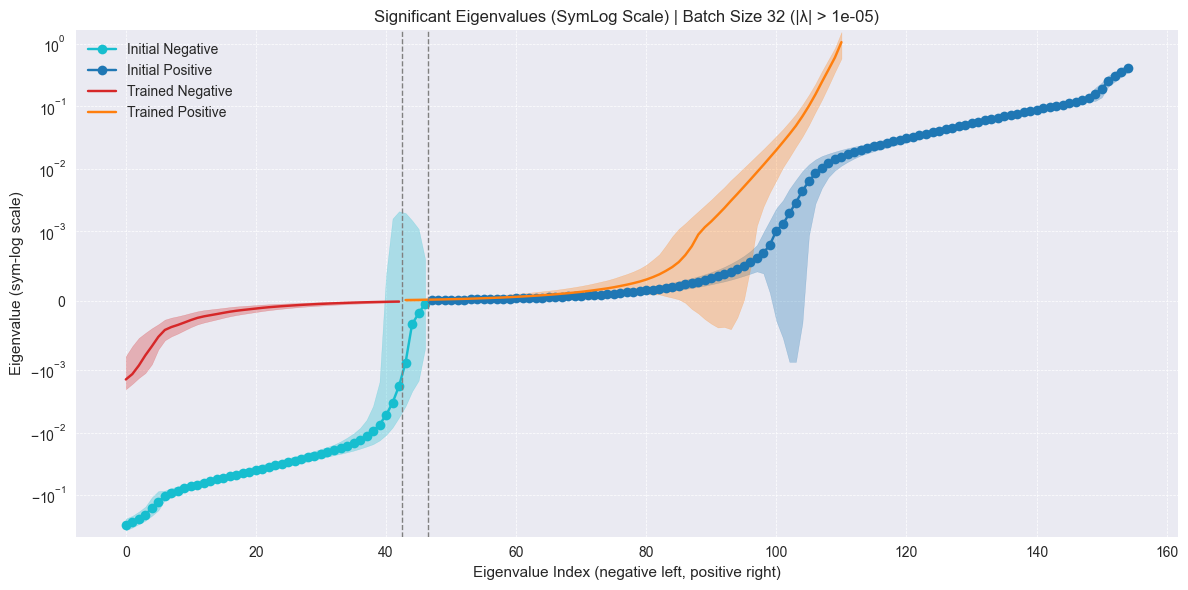

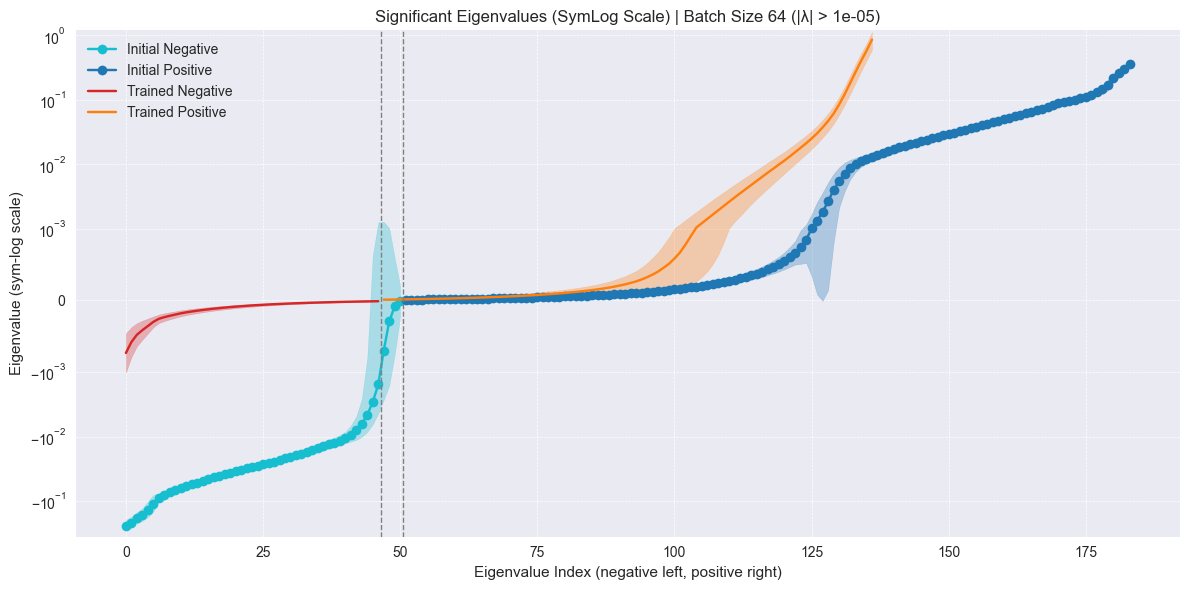

In [19]:
epsilon = 1e-5  # порог значимости

for batch_size in sorted(initial_hessians.keys()):
    init_eigs = get_eig_arrays(initial_hessians[batch_size])
    train_eigs = get_eig_arrays(trained_hessians[batch_size])

    mean_init = np.mean(init_eigs, axis=0)
    std_init = np.std(init_eigs, axis=0)

    mean_train = np.mean(train_eigs, axis=0)
    std_train = np.std(train_eigs, axis=0)

    # Маски значимых значений
    mask_pos_init = mean_init > epsilon
    mask_neg_init = mean_init < -epsilon

    mask_pos_train = mean_train > epsilon
    mask_neg_train = mean_train < -epsilon

    # Вырезаем значимые значения и их разброс
    def get_filtered_data(mean, std, mask):
        mean_f = mean[mask]
        std_f = std[mask]
        lower = np.where(mean_f >= 0, mean_f - std_f, mean_f + std_f)
        upper = np.where(mean_f >= 0, mean_f + std_f, mean_f - std_f)
        return mean_f, lower, upper

    mean_neg_init, lower_neg_init, upper_neg_init = get_filtered_data(mean_init, std_init, mask_neg_init)
    mean_pos_init, lower_pos_init, upper_pos_init = get_filtered_data(mean_init, std_init, mask_pos_init)

    mean_neg_train, lower_neg_train, upper_neg_train = get_filtered_data(mean_train, std_train, mask_neg_train)
    mean_pos_train, lower_pos_train, upper_pos_train = get_filtered_data(mean_train, std_train, mask_pos_train)

    # Создаем непрерывные индексы
    x_neg_init = np.arange(len(mean_neg_init))
    x_pos_init = np.arange(len(mean_pos_init)) + len(mean_neg_init)  # сдвиг вправо

    x_neg_train = np.arange(len(mean_neg_train))
    x_pos_train = np.arange(len(mean_pos_train)) + len(mean_neg_train)  # сдвиг вправо

    fig, ax = plt.subplots(figsize=(12, 6))

    # Рисуем Initial: сначала отрицательные, потом положительные (непрерывно)
    ax.plot(x_neg_init, mean_neg_init, 'o-', label='Initial Negative', color='tab:cyan')
    ax.fill_between(x_neg_init, lower_neg_init, upper_neg_init, color='tab:cyan', alpha=0.3)

    ax.plot(x_pos_init, mean_pos_init, 'o-', label='Initial Positive', color='tab:blue')
    ax.fill_between(x_pos_init, lower_pos_init, upper_pos_init, color='tab:blue', alpha=0.3)

    # Рисуем Trained: сначала отрицательные, потом положительные (непрерывно)
    ax.plot(x_neg_train, mean_neg_train, 'x-', label='Trained Negative', color='tab:red')
    ax.fill_between(x_neg_train, lower_neg_train, upper_neg_train, color='tab:red', alpha=0.3)

    ax.plot(x_pos_train, mean_pos_train, 'x-', label='Trained Positive', color='tab:orange')
    ax.fill_between(x_pos_train, lower_pos_train, upper_pos_train, color='tab:orange', alpha=0.3)

    # Добавим разделительную вертикальную линию между отрицательной и положительной частью
    split_pos_init = len(mean_neg_init) - 0.5
    split_pos_train = len(mean_neg_train) - 0.5
    ax.axvline(split_pos_init, color='gray', linestyle='--', linewidth=1)
    ax.axvline(split_pos_train, color='gray', linestyle='--', linewidth=1)

    ax.set_yscale('symlog', linthresh=1e-3)
    ax.set_title(f"Significant Eigenvalues (SymLog Scale) | Batch Size {batch_size} (|λ| > {epsilon})")
    ax.set_xlabel("Eigenvalue Index (negative left, positive right)")
    ax.set_ylabel("Eigenvalue (sym-log scale)")
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.legend()
    plt.tight_layout()
    plt.show()


In [18]:
mean_neg_train

array([], dtype=float32)

In [14]:
import numpy as np

def frobenius_norm(M):
    return np.linalg.norm(M, ord='fro')

for batch_size in sorted(initial_hessians.keys()):
    hessians = initial_hessians[batch_size]
    H_mean = np.mean(hessians, axis=0)

    norm_mean = frobenius_norm(H_mean)
    diffs_rel = [frobenius_norm(h - H_mean) / norm_mean for h in hessians]

    mean_diff_rel = np.mean(diffs_rel)
    std_diff_rel = np.std(diffs_rel)

    print(f"Batch size {batch_size}: mean relative Frobenius norm difference = {mean_diff_rel:.4f} ± {std_diff_rel:.4f}")


Batch size 2: mean relative Frobenius norm difference = 3.9919 ± 0.8556
Batch size 4: mean relative Frobenius norm difference = 2.7955 ± 0.4792
Batch size 8: mean relative Frobenius norm difference = 1.9845 ± 0.3537
Batch size 16: mean relative Frobenius norm difference = 1.3961 ± 0.2412
Batch size 32: mean relative Frobenius norm difference = 0.9647 ± 0.1738
Batch size 64: mean relative Frobenius norm difference = 0.6488 ± 0.1136


In [15]:
import numpy as np

def spectral_norm(M):
    return np.linalg.norm(M, ord=2)  # spectral norm

for batch_size in sorted(initial_hessians.keys()):
    hessians = initial_hessians[batch_size]
    H_mean = np.mean(hessians, axis=0)

    norm_mean = spectral_norm(H_mean)
    diffs_rel = [spectral_norm(h - H_mean) / norm_mean for h in hessians]

    mean_diff_rel = np.mean(diffs_rel)
    std_diff_rel = np.std(diffs_rel)

    print(f"Batch size {batch_size}: mean relative spectral norm difference = {mean_diff_rel:.4f} ± {std_diff_rel:.4f}")


Batch size 2: mean relative spectral norm difference = 3.5148 ± 0.6734
Batch size 4: mean relative spectral norm difference = 2.3789 ± 0.4874
Batch size 8: mean relative spectral norm difference = 1.6877 ± 0.3518
Batch size 16: mean relative spectral norm difference = 1.1868 ± 0.2424
Batch size 32: mean relative spectral norm difference = 0.8199 ± 0.1729
Batch size 64: mean relative spectral norm difference = 0.5504 ± 0.1140


Batch 2:
  Max eigenvalue initial: mean=1.1877, std=0.2275
  Max eigenvalue trained: mean=2.3998, std=3.7636


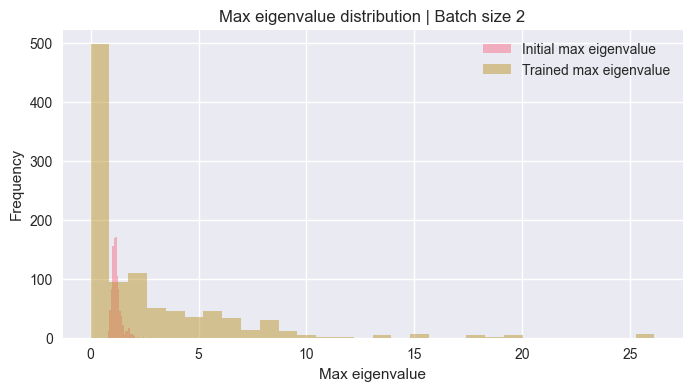

Batch 4:
  Max eigenvalue initial: mean=0.8473, std=0.1616
  Max eigenvalue trained: mean=2.0761, std=2.2532


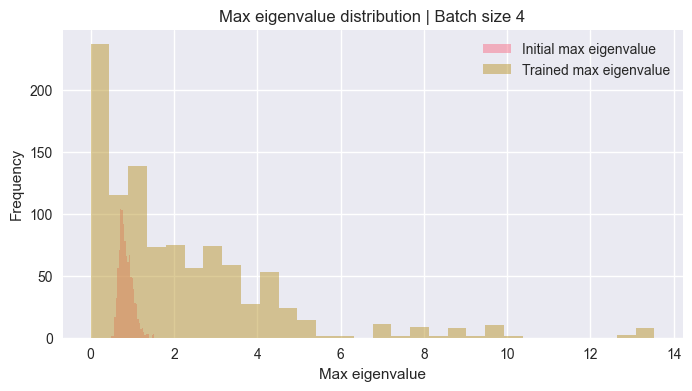

Batch 8:
  Max eigenvalue initial: mean=0.6349, std=0.1229
  Max eigenvalue trained: mean=1.7274, std=1.3555


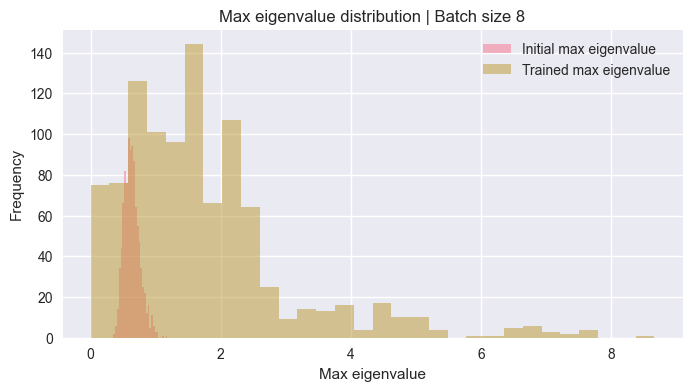

Batch 16:
  Max eigenvalue initial: mean=0.5000, std=0.0874
  Max eigenvalue trained: mean=1.3588, std=0.8049


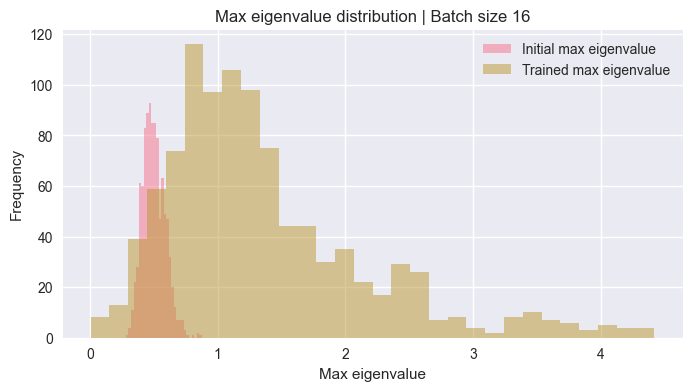

Batch 32:
  Max eigenvalue initial: mean=0.4144, std=0.0622
  Max eigenvalue trained: mean=1.0713, std=0.4843


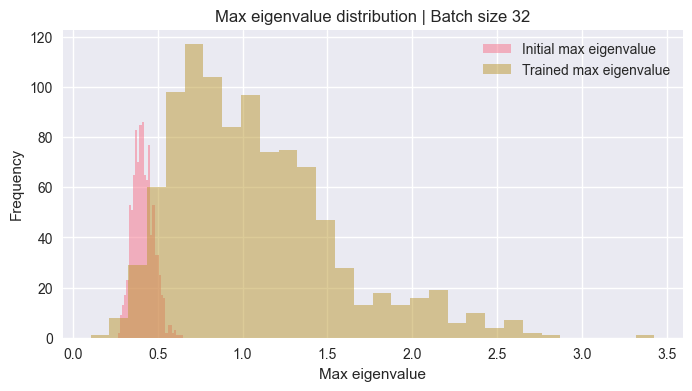

Batch 64:
  Max eigenvalue initial: mean=0.3635, std=0.0410
  Max eigenvalue trained: mean=0.8592, std=0.2629


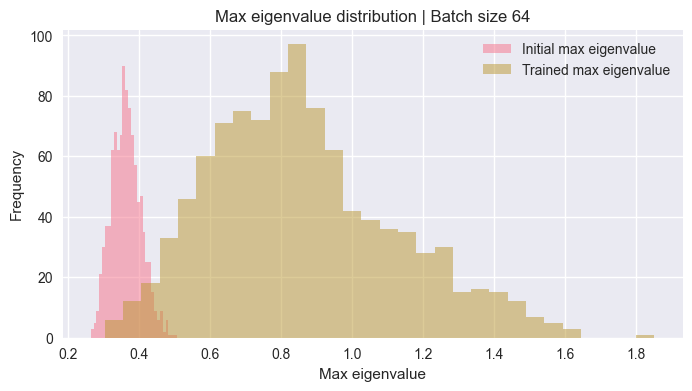

In [16]:
for batch_size in sorted(initial_hessians.keys()):
    init_eigs = get_eig_arrays(initial_hessians[batch_size])
    train_eigs = get_eig_arrays(trained_hessians[batch_size])

    max_init = np.max(init_eigs, axis=1)  # максимум по каждой матрице
    max_train = np.max(train_eigs, axis=1)

    print(f"Batch {batch_size}:")
    print(f"  Max eigenvalue initial: mean={np.mean(max_init):.4f}, std={np.std(max_init):.4f}")
    print(f"  Max eigenvalue trained: mean={np.mean(max_train):.4f}, std={np.std(max_train):.4f}")

    # Можно визуализировать распределения
    plt.figure(figsize=(8,4))
    plt.hist(max_init, bins=30, alpha=0.5, label='Initial max eigenvalue')
    plt.hist(max_train, bins=30, alpha=0.5, label='Trained max eigenvalue')
    plt.title(f'Max eigenvalue distribution | Batch size {batch_size}')
    plt.xlabel('Max eigenvalue')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()


In [17]:
import numpy as np
from numpy.linalg import eigvals, svd, norm

def hessian_stats(hessians):
    stats = []
    hs = np.stack(hessians)
    H_mean = np.mean(hs, axis=0)
    H2_mean = np.mean(hs @ hs, axis=0)

    for H in hessians:
        eigs = np.real(eigvals(H))
        svals = svd(H, compute_uv=False)

        frob = norm(H, ord='fro')
        spec = norm(H, ord=2)
        eig_mean = np.mean(eigs)
        eig_var = np.var(eigs)
        neg_frac = np.sum(eigs < 0) / len(eigs)
        zero_frac = np.sum(np.isclose(eigs, 0, atol=1e-5)) / len(eigs)
        sing_mean = np.mean(svals)
        sing_std = np.std(svals)
        trace = np.trace(H)
        trace_spec_ratio = trace / spec if spec > 0 else np.nan

        stats.append({
            'frobenius_norm': frob,
            'spectral_norm': spec,
            'eig_mean': eig_mean,
            'eig_var': eig_var,
            'neg_frac': neg_frac,
            'zero_frac': zero_frac,
            'singular_mean': sing_mean,
            'singular_std': sing_std,
            'trace_spec_ratio': trace_spec_ratio,
        })

    # Коммутатор
    comm = H_mean @ H2_mean - H2_mean @ H_mean
    comm_norm = norm(comm, ord='fro')

    return stats, comm_norm

# Подсчёт и агрегация по батч сайзам
batch_stats = {}

for batch_size in sorted(initial_hessians.keys()):
    init_stats, init_comm = hessian_stats(initial_hessians[batch_size])
    train_stats, train_comm = hessian_stats(trained_hessians[batch_size])

    def agg_stats(stats):
        return {k: np.mean([st[k] for st in stats]) for k in stats[0]}

    batch_stats[batch_size] = {
        'init': agg_stats(init_stats),
        'init_comm_norm': init_comm,
        'train': agg_stats(train_stats),
        'train_comm_norm': train_comm,
    }

import pandas as pd
summary_df = pd.DataFrame([
    {
        'batch_size': b,
        **{f"init_{k}": v for k, v in batch_stats[b]['init'].items()},
        'init_comm_norm': batch_stats[b]['init_comm_norm'],
        **{f"train_{k}": v for k, v in batch_stats[b]['train'].items()},
        'train_comm_norm': batch_stats[b]['train_comm_norm'],
    }
    for b in sorted(batch_stats.keys())
]).set_index('batch_size')

summary_df


,init_frobenius_norm,init_spectral_norm,init_eig_mean,init_eig_var,init_neg_frac,init_zero_frac,init_singular_mean,init_singular_std,init_trace_spec_ratio,init_comm_norm,train_frobenius_norm,train_spectral_norm,train_eig_mean,train_eig_var,train_neg_frac,train_zero_frac,train_singular_mean,train_singular_std,train_trace_spec_ratio,train_comm_norm
batch_size,,,,,,,,,,,,,,,,,,,,
2,3.083232,1.187705,0.003514,0.025865,0.160767,0.920969,0.029165,0.154167,1.161961,0.416412,2.468132,2.399835,0.007429,0.053951,0.266301,0.965847,0.007554,0.125393,1.038132,1.004320
4,2.245009,0.847311,0.003518,0.013464,0.189762,0.860238,0.026241,0.111176,1.649469,0.206749,2.200885,2.076143,0.007343,0.026964,0.304407,0.937153,0.007454,0.111767,1.292992,0.423241
8,1.668471,0.634891,0.003514,0.007438,0.224705,0.798484,0.023043,0.081701,2.207326,0.101603,1.908975,1.727442,0.007345,0.014861,0.330148,0.889028,0.007439,0.096872,1.634538,0.221839
16,1.293250,0.500028,0.003515,0.004432,0.256407,0.716365,0.020120,0.062649,2.791960,0.050793,1.596861,1.358807,0.007348,0.008573,0.348808,0.815909,0.007421,0.080932,2.142555,0.108390
32,1.047588,0.414429,0.003515,0.002888,0.243694,0.613334,0.017475,0.050362,3.344143,0.024543,1.350483,1.071332,0.007339,0.005449,0.348925,0.726927,0.007390,0.068335,2.733838,0.054840
64,0.898844,0.363451,0.003514,0.002107,0.228769,0.534142,0.015592,0.043004,3.777857,0.010980,1.179043,0.859230,0.007347,0.003808,0.315503,0.650630,0.007379,0.059554,3.377019,0.023370
